# Nonlinear Langevin with Double-Welled Potential

Here we take for out potential the function $$V(x) = 1/4(x^2-1)^2$$ and so the (overdamped, stochastic) Langenvin equation is $$dX_t = -V'(X_t)dt + \sigma dW_t = -X_t(X_t^2-1) + \sigma dW_t$$
We solve this numerically in various ways to get an approximate solution if to the equation. For instance we will often use Euler-Maruyama which soluction takes the form 
$$Y_{n+1} = Y_{n} + \Delta t\big(-Y_n(Y_n^2-1)\big) + \sigma \sqrt{\Delta t}v_n$$
where $Y_n \approx X_{\Delta t n}$ and $v_n \sim N(0,1)$ for all $n = 0,1,2,\dots$ are i.i.d.

The goal here is to reproduce the statisical and dynamical information (?). Of a realization of $Y = (Y_n;\;n=o,1,2,\dots)$ using a reduced model. We will compare the autocavariances as well as the pdf the $Y_n$. 

So, first we run the full model. To do this I use the function `DataGen_DWOL` found in th file `DataGen.jl` found in the current folder (`Examples\Nonlinear Langevin`).

In [1]:
using Plots
pyplot()

include("DataGen.jl") # This has many packages in it's preamble
include("../../Tools/Model_Reduction_Dev.jl")

vector_wiener_filter_fft

In [12]:
steps = 10^5 + 1
scheme = "FE"
t_start = 0
t_stop = 10^3
discard = 100000
sig_init = [1.5]
sigma = [.5]
V_prime = x -> -x.*(x.^2 .- 1)
SM1 = false
Obs_noise = false
d = 1
e = randn(d,steps + discard)


Y = DataGen_DWOL(
    steps;
    scheme, t_start, t_stop, discard, 
    sig_init , sigma, V_prime,
    SM1, Obs_noise, d, e
    )

T = range(t_start,stop = t_stop, length = steps)

0.0:0.01:1000.0

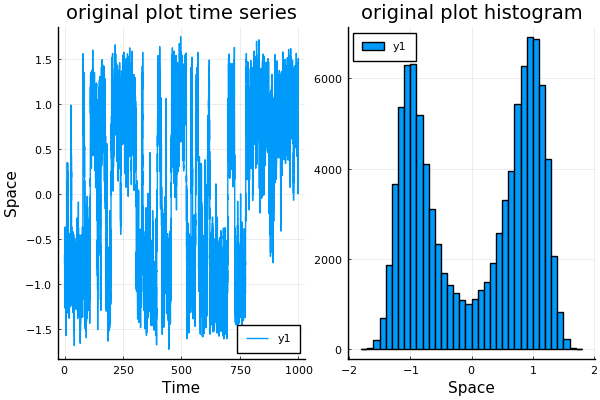

In [13]:
timeseries_plot(T,Y[:])

In [14]:
Psi(x) = [x; x.^3]

h_wf, pred = get_wf(Y,Psi, Preds = true);

Number of CKMS iterations: 1719
errK errR : 7.212147942350559e-11 1.047124165597582e-15


In [28]:
Y

1×100001 Array{Float64,2}:
 -0.780551  -0.873196  -0.825049  …  1.50742  1.48668  1.44057  1.43646

In [ ]:
Analytic WF

In [19]:
Δt = (t_stop - t_start)/(steps - 1)
h_ana = zeros(1,2,10)
h_ana[:,:,1] = [1+Δt -Δt]

1×2 Array{Float64,2}:
 1.01  -0.01

### Get `Y_hat`

In [22]:
M_h = size(h_ana,3)

Y_hat = zeros(size(Y)); 
Y_hat[:,1:M_h] = Y[:,1:M_h]
for i=M_h:steps-1
    Y_hat[:,i] = sum(h_ana[:,:,k+1]*pred[:,i-k]
                    for k = 0:M_h-1)
end

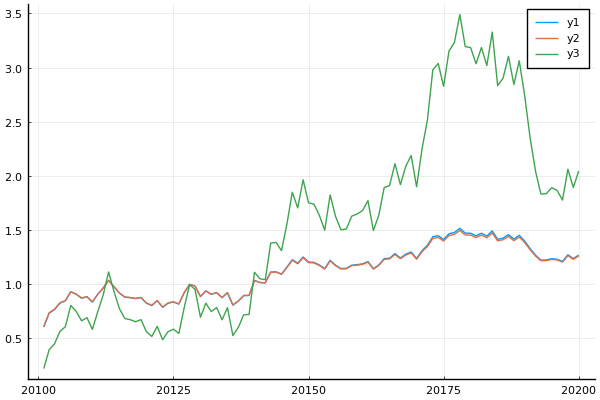

In [27]:
time = (1:100) .+ 20100
plot(time,[Y[1,time] Y_hat[1,time] real(pred[2,time])])